ANN for NARX

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from scipy.io import loadmat
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression

# out = loadmat(f'UnbalancedDisk-sim-data.mat')
data_dir = 'Data'
data_file = 'UnbalancedDisk-sim-data.mat'
out = loadmat(os.path.join(data_dir, data_file))
x = out['ulist'][0,:]
y = out['ylist'][0,:] 
x=x[0:3000]
y=y[0:3000]

In [2]:
na, nb = 2, 2
ulist = x
ylist = y
def make_training_data(ulist,ylist,na,nb):
    Xdata = []
    Ydata = []
    
    for k in range(max(na,nb),len(ulist)): 
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k])
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

from sklearn.model_selection import train_test_split 
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 

In [18]:
class Network(nn.Module):
    def __init__(self, n_in=4, n_neurons=64):
        super(Network,self).__init__()
        self.lay1 = nn.Linear(n_in,n_neurons).double()
        self.lay2 = nn.Linear(n_neurons,1).double()
    
    def forward(self,u):
        x1 = torch.relu(self.lay1(u)) 
        y = self.lay2(x1)[:,0] 
        return y

In [19]:
X_data=torch.from_numpy(Xtrain)
Y_data=torch.from_numpy(Ytrain)
X_val=torch.from_numpy(Xval)
Y_val=torch.from_numpy(Yval)

In [16]:
model = Network()
print(model)
parameters = list(model.parameters())
print(parameters) 
Loss_hist = []

optimizer = torch.optim.Adam(model.parameters(),lr=5e-4) 
for epoch in range(20000):
    Loss = torch.mean((model(X_data)-Y_data)**2)
    Loss_hist.append(Loss)
    optimizer.zero_grad()
    Loss.backward() 
    optimizer.step() 
    if epoch%1000==0: 
       print(f'epoch={epoch} Loss={Loss}')

Network(
  (lay1): Linear(in_features=4, out_features=32, bias=True)
  (lay2): Linear(in_features=32, out_features=1, bias=True)
)
[Parameter containing:
tensor([[ 4.9001e-01,  3.2094e-01, -4.0494e-01, -2.6529e-01],
        [-4.3737e-01, -3.7670e-01, -4.4591e-01, -8.9041e-02],
        [ 4.3216e-01,  4.6202e-01, -4.5280e-01, -9.1055e-02],
        [-2.0984e-01,  8.8190e-02, -4.4943e-01,  3.1812e-01],
        [-2.9571e-01, -2.6163e-01, -1.6104e-01, -1.7089e-01],
        [ 2.1017e-01,  1.3908e-01, -3.2036e-01, -4.2643e-01],
        [-2.0706e-02, -3.2047e-01, -9.1069e-02, -2.0182e-01],
        [-1.1302e-02, -2.0712e-01,  4.3016e-01, -2.0089e-01],
        [-4.5208e-01,  3.1330e-01,  5.3953e-02,  4.9278e-01],
        [-8.1088e-02, -3.3336e-01,  1.9437e-01, -3.4076e-01],
        [-4.6527e-04, -2.0517e-01, -1.9871e-01, -4.7459e-01],
        [ 1.9487e-01, -3.2199e-01, -1.0616e-01,  4.7024e-01],
        [ 1.9157e-01, -1.0263e-01, -2.2968e-01, -1.6875e-01],
        [ 4.6952e-01,  2.7970e-01, -1.68

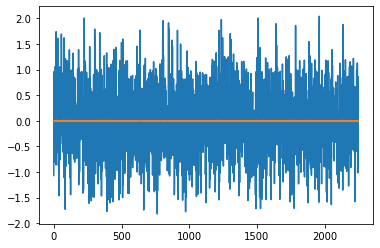

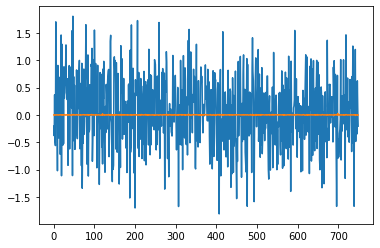

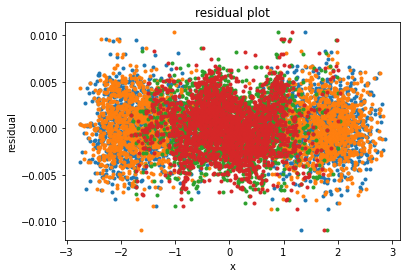

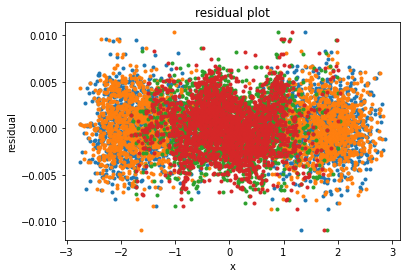

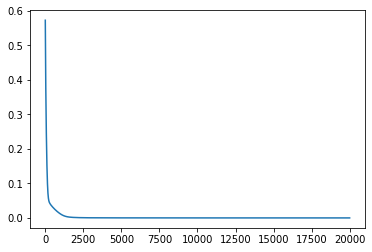

In [17]:
with torch.no_grad():
    plt.plot(model(X_data),label='predicted')
    plt.plot(model(X_data)-Y_data,label='error')  
    plt.show()

    plt.plot(model(X_val),label='predicted')
    plt.plot(model(X_val)-Y_val,label='error')     
    plt.show()

    plt.title('residual plot')
    plt.xlabel('x')
    plt.ylabel('residual')
    plt.plot(X_data,Y_data-model(X_data),'.')
    plt.show()

    plt.title('residual plot')
    plt.xlabel('x')
    plt.ylabel('residual')
    plt.plot(X_data,Y_data-model(X_data),'.')
    plt.show()
    
    plt.plot(Loss_hist)
    plt.show
